# Lesson 10 Transfer Learning

~~~
conda install panda numpy tensorflow keras 
~~~

It is recommended to run the notebook in Google Colaboratory environment. The notebook has been tested to run without dependencies on local files.

## Downloading the dataset 

We download the dataset which contains the training data and  save it to the current folder of the runtime.

In [0]:
zip_file_url = 'https://storage.googleapis.com/oscon-tf-workshop-materials/transfer_learning/hugs_photos.zip'
  
import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(".")

Checking whether the files has been extracted successfully. We should see two directories 'hugs' and 'not-hugs' under hugs_photos directory

In [2]:
!ls hugs_photos

hugs  not-hugs


## Preparing the training data

We construct a DataFrame with the folder and the class based on the two folders that we extracted

In [0]:
import pandas as pd
import os

list_of_files = []
for element in os.listdir('hugs_photos/hugs'):
  list_of_files.append(['HUG','hugs_photos/hugs/'+element])

for element in os.listdir('hugs_photos/not-hugs'):
  list_of_files.append(['NOHUG','hugs_photos/not-hugs/'+element])
  
data_labels = pd.DataFrame.from_records(list_of_files, columns=['class','image_path'])

In [4]:
data_labels.head()

,class,image_path
0,HUG,hugs_photos/hugs/3014094249_895973edaf.jpg
1,HUG,hugs_photos/hugs/9166844683_bd595964ec_z.jpg
2,HUG,hugs_photos/hugs/158786811_7f011e93c7.jpg
3,HUG,hugs_photos/hugs/8517659367_9bbfa7ed24.jpg
4,HUG,hugs_photos/hugs/16368431818_6867d4c3bc.jpg


In [5]:
target_labels = data_labels['class']
target_labels.head()

0    HUG
1    HUG
2    HUG
3    HUG
4    HUG
Name: class, dtype: object

In [6]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import numpy as np

# load dataset
train_data = np.array([img_to_array(load_img(img, target_size=(299, 299)))
                           for img in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

# create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(train_data, target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

# create train and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

print('Initial Dataset Size:', train_data.shape)
print('Initial Train and Test Datasets Size:', x_train.shape, x_test.shape)
print('Train and Validation Datasets Size:', x_train.shape, x_val.shape)
print('Train, Test and Validation Datasets Size:', x_train.shape, x_test.shape, x_val.shape)

Using TensorFlow backend.


Initial Dataset Size: (319, 299, 299, 3)
Initial Train and Test Datasets Size: (189, 299, 299, 3) (96, 299, 299, 3)
Train and Validation Datasets Size: (189, 299, 299, 3) (34, 299, 299, 3)
Train, Test and Validation Datasets Size: (189, 299, 299, 3) (96, 299, 299, 3) (34, 299, 299, 3)


Doing One Shot Encoding for our data

In [7]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).values
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).values
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).values

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((189, 2), (96, 2), (34, 2))

## Prepare the image data for training

In [0]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, 
                                     batch_size=BATCH_SIZE, seed=1)
                                     
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, 
                                   batch_size=BATCH_SIZE, seed=1)                                     


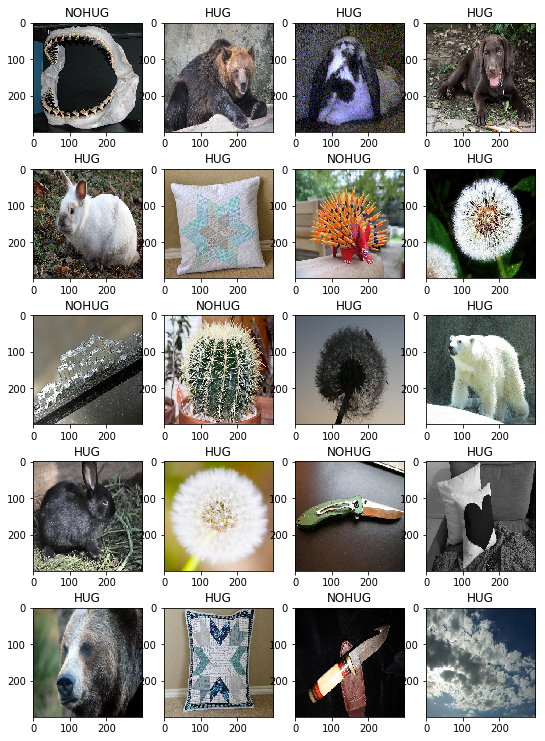

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

y_train_values = y_train.values
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5
idx = 0
ax = []
for i in range(columns*rows):
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(y_train_values[idx])  # set title
    plt.imshow(x_train[idx]/255)
    idx=idx+1

# Transfer Learning

This is where we construct our model based on InceptionV3. We have some flexibility to determine the architecture of our custom classifier. For simple classifier, Dense layer is quite commonly used. 

In [10]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras import backend as k 

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(299, 299, 3))

model = Sequential()
model.add(base_inception)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
total_classes = y_train_ohe.shape[1]
model.add(Dense(total_classes, activation='softmax'))


# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

W0619 16:12:19.733884 139625819326336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 16:12:19.750103 139625819326336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 16:12:19.762931 139625819326336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 16:12:19.800388 139625819326336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0619 16:12:19.801707 1396258193

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 23,115,554
Trainable params: 1,312,770
Non-trainable params: 21,802,784
________________________________________________________

In [11]:
# Train the model
batch_size = 15
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15, verbose=1, callbacks=[es])

W0619 16:12:40.122816 139625819326336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
12/12 [==============================] - 21s 2s/step - loss: 0.6395 - acc: 0.6120 - val_loss: 0.4977 - val_acc: 0.9412
Epoch 2/15
12/12 [==============================] - 4s 334ms/step - loss: 0.4472 - acc: 0.8560 - val_loss: 0.3750 - val_acc: 0.9412
Epoch 3/15
12/12 [==============================] - 7s 619ms/step - loss: 0.3601 - acc: 0.8856 - val_loss: 0.2963 - val_acc: 0.8824
Epoch 4/15
12/12 [==============================] - 7s 617ms/step - loss: 0.2681 - acc: 0.9388 - val_loss: 0.2183 - val_acc: 0.9412
Epoch 5/15
12/12 [==============================] - 7s 604ms/step - loss: 0.1943 - acc: 0.9601 - val_loss: 0.2062 - val_acc: 0.9118
Epoch 6/15
12/12 [==============================] - 7s 612ms/step - loss: 0.1610 - acc: 0.9601 - val_loss: 0.2175 - val_acc: 0.9118
Epoch 7/15
12/12 [==============================] - 7s 599ms/step - loss: 0.1132 - acc: 0.9760 - val_loss: 0.1046 - val_acc: 0.9706
Epoch 8/15
12/12 [==============================] - 7s 606ms/step - loss: 0.12

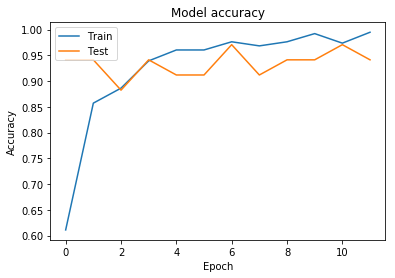

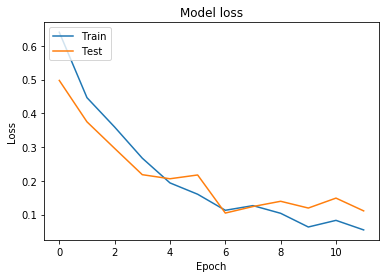

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
from PIL import Image
import requests
from io import BytesIO

def predict_image(url):
  img_path = 'infer.jpg'
  urllib.request.urlretrieve(url, 'infer.jpg')
  import matplotlib.image as mpimg
  img=mpimg.imread('infer.jpg')
  imshow(img) 
  infer_data = np.array([img_to_array(load_img(img_path, target_size=(299, 299)))
                      ]).astype('float32')
  result = model.predict(infer_data)
  if result[0][0]>0.99:
    return "HUG"
  else:
    return "NOHUG"
  

'HUG'

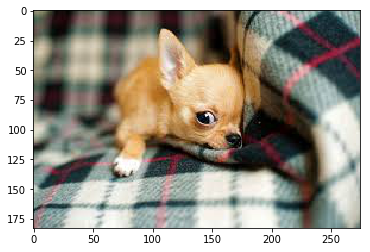

In [68]:
predict_image('https://raw.githubusercontent.com/amygdala/tensorflow-workshop/master/workshop_sections/transfer_learning/cloudml/prediction_images/puppy1.jpg')

'HUG'

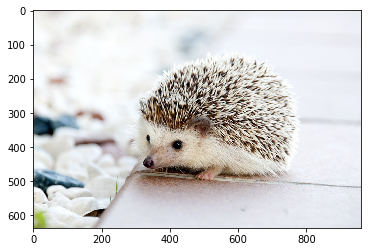

In [69]:
predict_image('http://amygdala.github.io/images/hedgehog.jpg')

'NOHUG'

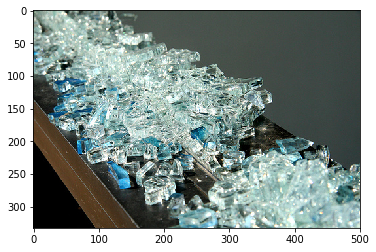

In [70]:
predict_image('https://raw.githubusercontent.com/amygdala/tensorflow-workshop/master/workshop_sections/transfer_learning/cloudml/prediction_images/247769206_a5a564ee8a.jpg')